# Importance Sampling

> Demonstrating the utility of importance sampling, which allows you to calculate sample means without actually sampling!

Importance sampling provides a way to estimate the mean of a distribution when you know the probabilities, but cannot sample from it. This is useful in RL because often you have a policy which you can generate transition probabilities from, but you can’t actually sample. Like if you had an unsafe situation that you couldn’t repeat; you could use importance sampling to calculate the expected value without repeating the unsafe act.

The crux of it is the equation:

$$\frac{1}{n} \sum^{n}_{i=1} \frac{ x_i g(x_i) } {f(x_i)}$$

Where,
- $n$ is the number of trials,
- $x_i$ is the current sample from the first distribution,
- $f()$ is the probability function for the first distribution and,
- $g()$ is the probability function for the second distribution.



## Setup

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator, MultipleLocator
from pathlib import Path

## Dice Simulators
Now allow me to generate some dice simulators. These are the probability functions like f(). First I create a function that simulates a fair die. Then I create a second die, which is weighted towards rolling sixes.

Remember that I am not going to roll the second die. I only have the probability distribution. Think of this as like a policy, it’s telling us how this “agent” will behave.

In [ ]:
x = np.arange(1,7) # dice values

# Initialise first die
f_x = lambda: np.random.choice(x)
fair_expected = np.sum(1/6 * x)
print(f"Fair expected value = {fair_expected}")

# Initialise the second die
# Note, we are not actually rolling this die
weights = x / np.sum(x) # a die weighted towards rolling sixes
biased_expected = np.sum(weights * x)
print(f"Biased expected value = {biased_expected}")

Fair expected value = 3.5
Biased expected value = 4.333333333333333


I print the actual sample means to later check that the importance sampling is getting the right results. In the real world, we can’t simply print the sample mean.



## Importance Sampling Trials

The key to importance sampling is that the estimate of the sample mean improves with more invocations. So next I simulate throwing the first die 100 times. Then I will plot the result of the importance sampling equation for each step.

In [ ]:
trials_fair = []
for i in range(100):
    trials_fair.append(f_x())

## Plotting Helpers

In [ ]:
forground_colours = [
    '#111111',
    '#666666',
    '#CCCCCC',
]

def format_top_axis(ax):
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.set_ylim(top=35)
    ax.set_xlabel("Value")
    

def format_bottom_axis(ax):
    ax.xaxis.set_major_locator(MultipleLocator(50))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_ylim(bottom=1, top=6)
    ax.set_xlabel("Iteration number")
    # ax.legend()

## Results
Below I’m taking the trials, calculating the various quantities and plotting the results. I’ll describe the results below.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


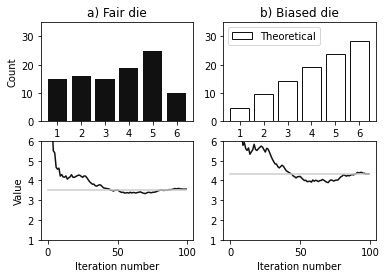

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)
h, _ = np.histogram(trials_fair, bins=np.linspace(0.5, 6.5, 7))
ax[0,0].bar(x, h, color=forground_colours[0])
format_top_axis(ax[0,0])
ax[0,0].set_ylabel("Count")
ax[0,0].set_title("a) Fair die")

ax[0,1].bar(x, weights * len(trials_fair), color='w', edgecolor=forground_colours[0], label="Theoretical")
format_top_axis(ax[0,1])
ax[0,1].legend()
ax[0,1].set_title("b) Biased die")

# Plot sample mean of fair die
index = np.arange(len(trials_fair))
fair_mean = np.cumsum(trials_fair) / index
ax[1,0].plot(index, fair_mean, color=forground_colours[0], label="Sample mean")
ax[1,0].plot(index, [fair_expected]*len(index), color=forground_colours[2], label="Population mean")
format_bottom_axis(ax[1,0])
ax[1,0].set_ylabel("Value")

# Plot sample mean of biased die without actually rolling
index = np.arange(len(trials_fair))
resampled = trials_fair * weights[np.subtract(trials_fair, 1)] / (1/6)
biased_mean = np.cumsum(resampled) / index
ax[1,1].plot(index, biased_mean, color=forground_colours[0], label="Sample mean")
ax[1,1].plot(index, [biased_expected]*len(index), color=forground_colours[2], label="Population mean")
format_bottom_axis(ax[1,1])
plt.show()

Let me explain that plot. In the top left we have a histogram of actual rolls for the first die. You can see it’s just about uniform. In the top right we have the theoretical probability distribution for the second die (g()). We can’t roll this.

In the bottom left I’m calculating the actual mean after rolling the first die. In the bottom right I’m using the importance sampling equation to estimate the sample mean. Note how it converges to the expected value of 4.33. Magic!

Importance sampling is possible because it is assumed that the two probability distributions are sampling from the same environment. If they weren’t then you’d be comparing apples with pumpkins. This is useful in RL because quite often we have one agent (an actor, for example) operating in the environment but another agent which is not (a critic, for example).

But this can also be used in other ways, like when doing shadow deployments, where one operational agent continues to serve users, and a second hidden agent (maybe a new experimental agent) is using importance sampling to gather intelligence from the environment using its own policy.